## baseline lightning trainer notebook

Created on: Wednesday March 16th, 2022  
Created by: Jacob Alexander Rose  

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.utils.etl_utils import ETL

import pytorch_lightning as pl
from torchvision import transforms as T
import argparse
import imutils
from hydra.experimental import compose, initialize, initialize_config_dir
import hydra
from omegaconf import DictConfig, OmegaConf
from typing import *
default_reader = None
import torchmetrics

from imutils.ml.models.pl import classifier

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer


import wandb
import os
from pathlib import Path
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
# api = wandb.Api()
# run = api.run("jrose/herbarium2022/37r673ke")
import imutils
from imutils.ml.utils.etl_utils import ETL
from omegaconf import DictConfig, OmegaConf

from rich import print as pp

Importing imutils


## Load test config

In [3]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

print(config_path, config_name)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["data.datamodule.num_workers=4",
                                              "data/datamodule@data=herbarium2022-res_512_datamodule",
                                              "train.pl_trainer.accelerator=gpu",
                                              "model_cfg.backbone.name=resnext50_32x4d",
                                              "+train.pl_trainer.limit_train_batches=2",
                                              "hp.batch_size=16",
                                              "hp.resolution=224",
                                              "+train.pl_trainer.limit_val_batches=2",
                                              "train.pl_trainer.log_every_n_steps=10",
                                              "train.pl_trainer.devices=1",
                                              "train.pl_trainer.strategy=null",
                                              # 'model_cfg/loss=class-balanced-ce-loss',
                                              # "model_cfg.loss.beta=0.99",
                                              "data.datamodule.transform_cfg.skip_augmentations=true"],
                                 cfg = None)

OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = cfg.core.experiments_root_dir #"/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)

# print(OmegaConf.to_yaml(cfg.hydra))#, resolve=True, sort_keys=True))
# pp(OmegaConf.to_container(cfg, resolve=True))

/media/data_cifs/projects/prj_fossils/users/jacob/github/image-utils/imutils/ml/conf base_conf.yaml
name 'HydraConfig' is not defined
/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022


In [4]:
from imutils.ml.utils.experiment_utils import (configure_callbacks,
                                               configure_loggers,
                                               configure_trainer,
                                               configure_loss_func)
import hydra
if cfg.execution_list.model_fit:

    hydra.utils.log.info(f"Executing train stage: model_fit")

    hydra.utils.log.info(f"Instantiating <{cfg.data.datamodule._target_}>")
    datamodule = hydra.utils.instantiate(
        cfg.data.datamodule, _recursive_=False
    )
    datamodule.setup()

    loss_func = configure_loss_func(cfg, targets=datamodule.train_dataset.df.y)

# logging.warning("1. Before model, before trainer")
hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(cfg.model, cfg=cfg, _recursive_=False)
model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                                      loss_func=cfg.model_cfg.loss)

# logging.warning("2. After model, before trainer")
# ic(torch.cuda.current_device())	
# ic(torch.cuda.get_device_name(0))
wandb_logger = configure_loggers(cfg=cfg, model=model)
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train)	
hydra.utils.log.info(f"Instantiating the Trainer")
pp(OmegaConf.to_container(cfg.train.pl_trainer))
trainer = configure_trainer(cfg,
                            callbacks=callbacks,
                            logger=wandb_logger)
# logging.warning("3. After model, after trainer, before fit")
# ic(torch.cuda.current_device())
num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]
hydra.utils.log.info("Starting training with {} classes across {} images in batches of {} images each.".format(
    num_classes,
    num_samples,
    batch_size))

self.transform_cfg:


{'preprocess': {'train': {'resize': 256}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224, 'skip_augmentations': 
True}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 671817
    num_batches: 41989
    self.num_classes: 15501
    self.batch_size: 16
ic| subset: 'val'
    num_samples: 167955
    num_batches: 10498
    self.num_classes: 15501
    self.batch_size: 16
ic| subset: 'test'
    num_samples: 210407
    num_batches: 13151
    self.num_classes: 15501
    self.batch_size: 16


Initializing weights of the model head.
input_size: (1, 3, 224, 224)


wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)


2022-04-04 05:55:31,353 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.wandb_callbacks.ModuleDataMonitor>


type(submodules):  <class 'list'>


{
    '_target_': 'pytorch_lightning.Trainer',
    'fast_dev_run': False,
    'accelerator': 'gpu',
    'devices': 1,
    'precision': 16,
    'enable_model_summary': True,
    'log_every_n_steps': 10,
    'max_epochs': '${hp.max_epochs}',
    'accumulate_grad_batches': 1,
    'strategy': None,
    'limit_train_batches': 2,
    'limit_val_batches': 8
}

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
pp(OmegaConf.to_container(cfg, resolve=True))
results = trainer.fit(model=model, datamodule=datamodule)

{
    'core': {
        'name': 'herbarium2022-res512__resnext50_32x4d',
        'version': '0.0.1',
        'experiments_root_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022',
        'tags': ['herbarium2022', 'kaggle']
    },
    'seed': 42,
    'run_output_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022',
    'checkpoint_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/ckpts',
    'execution_list': {'auto_lr_tune': True, 'model_fit': True},
    'hp': {
        'num_classes': 15501,
        'batch_size': 16,
        'preprocess_size': 256,
        'resolution': 224,
        'num_channels': 3,
        'warmup_epochs': 3,
        'max_epochs': 30,
        'lr': 0.001,
        'freeze_backbone': False,
        'freeze_backbone_up_to': -1
    },
    'optim': {
        'optimizer': {
            '_target_': 'torch.optim.Adam',
            'lr': 0.001,
            'betas': [0.9, 0.999],
            'eps': 1e-08,
            'weight_decay': 0.0
        },
        'exclude_bn_bias': True,
        'use_lr_scheduler': True,
        'lr_scheduler': {
            '_target_': 'pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR',
            'warmup_epochs': 3,
            'max_epochs': 30,
            'warmup_start_lr': 0.0001,
            'eta_min': 1e-06,
            'last_epoch': -1
        }
    },
    'logging': {
        'log_model_summary': True,
        'log_dataset_summary': True,
        'n_elements_to_log': 32,
        'normalize_visualization': True,
        'val_check_interval': 1.0,
        'progress_bar_refresh_rate': 20,
        'wandb': {
            'project': 'herbarium2022',
            'entity': 'jrose',
            'name': 'herbarium2022-res512__resnext50_32x4d',
            'log_model': True,
            'tags': ['herbarium2022', 'kaggle']
        }
    },
    'pretrain': {
        'lr_tuner': {
            'hparams_path': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/20
22/herbarium2022/pretrain/lr_tuner_hparams.yaml',
            'tuner': {
                'min_lr': 1e-08,
                'max_lr': 1.0,
                'num_training': 100,
                'mode': 'exponential',
                'early_stop_threshold': 10.0
            },
            'pl_trainer': {
                '_target_': 'pytorch_lightning.Trainer',
                'precision': 16,
                'enable_progress_bar': True,
                'devices': 1,
                'accelerator': 'gpu',
                'deterministic': True,
                'benchmark': True,
                'auto_select_gpus': True,
                'auto_lr_find': True
            }
        }
    },
    'data': {
        'datamodule': {
            '_target_': 'imutils.ml.data.datamodule.Herbarium2022DataModule',
            'name': 'herbarium2022-res512',
            'catalog_dir': '/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-202
2-fgvc9_resize-512/catalogs',
            'label_col': 'scientificName',
            'train_size': 0.8,
            'shuffle': True,
            'seed': 14,
            'batch_size': 16,
            'num_workers': 4,
            'pin_memory': True,
            'persistent_workers': False,
            'transform_cfg': {
                'preprocess_size': 256,
                'resolution': 224,
                'preprocess': {
                    'train': {'resize': 256},
                    'val': {'resize': 256},
                    'test': {'resize': 256}
                },
                'batch_transform': {
                    'random_flips': False,
                    'train': {'random_resize_crop': 224},
                    'val': {'center_crop': 224},
                    'test': {'center_crop': 224}
                },
                'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]],
                'skip_augmentations': True
            },
            'remove_

ic| subset: 'train'
    num_samples: 671817
    num_batches: 41989
    self.num_classes: 15501
    self.batch_size: 16
ic| subset: 'val'
    num_samples: 167955
    num_batches: 10498
    self.num_classes: 15501
    self.batch_size: 16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


{
    '_target_': 'torch.optim.Adam',
    'lr': 0.001,
    'betas': [0.9, 0.999],
    'eps': 1e-08,
    'weight_decay': 0.0
}


  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | CrossEntropyLoss | 0     
1 | train_metric | MetricCollection | 0     
2 | val_metric   | MetricCollection | 0     
3 | test_metric  | MetricCollection | 0     
4 | net          | Sequential       | 57.3 M
--------------------------------------------------
57.3 M    Trainable params
0         Non-trainable params
57.3 M    Total params
114.545   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 0, self.global_step: 0, loss: 10.50390625
validation_step_end -> self.current_epoch: 0, self.global_step: 0, loss: 10.0859375
self.validation_epoch_end:  device:0, len(outputs)=2, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 0, self.global_step: 0, losses: tensor([10.5039, 10.0859], device='cuda:0')
ModuleDataMonitor is now tracking the following submodules:


/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1938: PossibleUserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


[
    'net.backbone.conv1',
    'net.backbone.bn1',
    'net.backbone.act1',
    'net.backbone.layer4.2.act3',
    'net.head'
]

Training: 0it [00:00, ?it/s]

input_size: (1, 3, 224, 224)
training_step_end -> self.current_epoch: 0, self.global_step: 0, loss: 10.07177734375
training_step_end -> self.current_epoch: 0, self.global_step: 1, loss: 9.798828125


Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 10.3671875
validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 10.1142578125
validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 9.9140625
validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 9.99462890625
validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 9.91357421875
validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 10.11572265625
validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 10.3955078125
validation_step_end -> self.current_epoch: 0, self.global_step: 2, loss: 9.77490234375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 0, self.global_step: 2, losses: tensor([10.3672, 10.1143,  9.9141,  9.9946,  9.9136, 10.1157, 10.3955,  9.7749],
       dev

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 10.18017578125
validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 9.85693359375
validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 9.7646484375
validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 10.01416015625
validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 9.95947265625
validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 10.0810546875
validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 10.140625
validation_step_end -> self.current_epoch: 1, self.global_step: 4, loss: 9.94677734375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 1, self.global_step: 4, losses: tensor([10.1802,  9.8569,  9.7646, 10.0142,  9.9595, 10.0811, 10.1406,  9.9468],
       

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 9.578125
validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 9.6865234375
validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 9.96533203125
validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 9.82421875
validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 10.01318359375
validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 9.87109375
validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 9.7294921875
validation_step_end -> self.current_epoch: 2, self.global_step: 6, loss: 9.59423828125
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 2, self.global_step: 6, losses: tensor([ 9.5781,  9.6865,  9.9653,  9.8242, 10.0132,  9.8711,  9.7295,  9.5942],
       device='c

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.6083984375
validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.5546875
validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.78271484375
validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.75146484375
validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.771484375
validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.98193359375
validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.67919921875
validation_step_end -> self.current_epoch: 3, self.global_step: 8, loss: 9.54248046875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 3, self.global_step: 8, losses: tensor([9.6084, 9.5547, 9.7827, 9.7515, 9.7715, 9.9819, 9.6792, 9.5425],
       device='cuda

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 9.67529296875
validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 9.63330078125
validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 9.85986328125
validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 9.77587890625
validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 9.7412109375
validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 10.04345703125
validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 9.591796875
validation_step_end -> self.current_epoch: 4, self.global_step: 10, loss: 9.67529296875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 4, self.global_step: 10, losses: tensor([ 9.6753,  9.6333,  9.8599,  9.7759,  9.7412, 10.0435,  9.5918,  9.6753

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 9.83642578125
validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 9.954345703125
validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 9.896484375
validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 10.0498046875
validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 9.94677734375
validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 10.07666015625
validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 9.73583984375
validation_step_end -> self.current_epoch: 5, self.global_step: 12, loss: 9.68359375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 5, self.global_step: 12, losses: tensor([ 9.8364,  9.9543,  9.8965, 10.0498,  9.9468, 10.0767,  9.7358,  9.6836]

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 10.10791015625
validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 10.185546875
validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 10.13671875
validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 10.3623046875
validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 10.48193359375
validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 10.390625
validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 10.142578125
validation_step_end -> self.current_epoch: 6, self.global_step: 14, loss: 9.9375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 6, self.global_step: 14, losses: tensor([10.1079, 10.1855, 10.1367, 10.3623, 10.4819, 10.3906, 10.1426,  9.9375],
       d

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 10.845703125
validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 11.391845703125
validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 10.764404296875
validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 11.421630859375
validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 11.93505859375
validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 11.24267578125
validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 11.171875
validation_step_end -> self.current_epoch: 7, self.global_step: 16, loss: 10.55810546875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 7, self.global_step: 16, losses: tensor([10.8457, 11.3918, 10.7644, 11.4216, 11.9351, 11.2427, 11.1719, 1

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 13.7646484375
validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 13.593017578125
validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 13.3779296875
validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 14.211669921875
validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 15.65869140625
validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 14.37744140625
validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 14.79931640625
validation_step_end -> self.current_epoch: 8, self.global_step: 18, loss: 12.84814453125
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 8, self.global_step: 18, losses: tensor([13.7646, 13.5930, 13.3779, 14.2117, 15.6587, 14.3774, 14.799

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 20.466796875
validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 20.779296875
validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 20.08544921875
validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 19.725830078125
validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 21.75634765625
validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 22.00537109375
validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 21.49853515625
validation_step_end -> self.current_epoch: 9, self.global_step: 20, loss: 18.6123046875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 9, self.global_step: 20, losses: tensor([20.4668, 20.7793, 20.0854, 19.7258, 21.7563, 22.0054, 21.4985, 1

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 28.1806640625
validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 31.78515625
validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 30.31787109375
validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 27.330078125
validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 29.580078125
validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 31.6357421875
validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 31.66650390625
validation_step_end -> self.current_epoch: 10, self.global_step: 22, loss: 27.35693359375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 10, self.global_step: 22, losses: tensor([28.1807, 31.7852, 30.3179, 27.3301, 29.5801, 31.6357, 31.666

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 29.830078125
validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 35.2509765625
validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 33.06591796875
validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 28.87255859375
validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 32.5986328125
validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 33.4755859375
validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 33.9482421875
validation_step_end -> self.current_epoch: 11, self.global_step: 24, loss: 30.4091796875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 11, self.global_step: 24, losses: tensor([29.8301, 35.2510, 33.0659, 28.8726, 32.5986, 33.4756, 33.9

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 26.23046875
validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 31.283203125
validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 29.204345703125
validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 25.59423828125
validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 29.9677734375
validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 29.70751953125
validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 30.12744140625
validation_step_end -> self.current_epoch: 12, self.global_step: 26, loss: 27.4833984375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 12, self.global_step: 26, losses: tensor([26.2305, 31.2832, 29.2043, 25.5942, 29.9678, 29.7075, 30.

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 23.103515625
validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 27.2353515625
validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 24.356689453125
validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 22.318359375
validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 26.52587890625
validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 27.30126953125
validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 27.205078125
validation_step_end -> self.current_epoch: 13, self.global_step: 28, loss: 25.17041015625
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 13, self.global_step: 28, losses: tensor([23.1035, 27.2354, 24.3567, 22.3184, 26.5259, 27.3013, 27.

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 18.8671875
validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 21.994140625
validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 19.404052734375
validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 18.52392578125
validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 21.5400390625
validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 22.7197265625
validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 22.92626953125
validation_step_end -> self.current_epoch: 14, self.global_step: 30, loss: 21.255859375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 14, self.global_step: 30, losses: tensor([18.8672, 21.9941, 19.4041, 18.5239, 21.5400, 22.7197, 22.926

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 16.2119140625
validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 18.7041015625
validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 17.029296875
validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 16.135986328125
validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 18.43212890625
validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 19.236328125
validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 20.23095703125
validation_step_end -> self.current_epoch: 15, self.global_step: 32, loss: 18.279296875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 15, self.global_step: 32, losses: tensor([16.2119, 18.7041, 17.0293, 16.1360, 18.4321, 19.2363, 20.2

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 13.6357421875
validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 15.109375
validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 14.273193359375
validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 13.768798828125
validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 14.9755859375
validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 15.69677734375
validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 17.3388671875
validation_step_end -> self.current_epoch: 16, self.global_step: 34, loss: 14.7734375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 16, self.global_step: 34, losses: tensor([13.6357, 15.1094, 14.2732, 13.7688, 14.9756, 15.6968, 17.3389

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 11.23779296875
validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 11.844970703125
validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 11.73095703125
validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 11.797607421875
validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 11.71142578125
validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 12.18359375
validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 13.68212890625
validation_step_end -> self.current_epoch: 17, self.global_step: 36, loss: 11.42236328125
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 17, self.global_step: 36, losses: tensor([11.2378, 11.8450, 11.7310, 11.7976, 11.7114, 12.1836

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 10.3193359375
validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 10.6044921875
validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 10.51513671875
validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 10.7451171875
validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 10.44873046875
validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 10.623046875
validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 11.640625
validation_step_end -> self.current_epoch: 18, self.global_step: 38, loss: 10.25244140625
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 18, self.global_step: 38, losses: tensor([10.3193, 10.6045, 10.5151, 10.7451, 10.4487, 10.6230, 11.6406

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 10.01123046875
validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 10.08251953125
validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 10.081787109375
validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 10.140625
validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 9.962890625
validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 10.11669921875
validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 10.603515625
validation_step_end -> self.current_epoch: 19, self.global_step: 40, loss: 9.92822265625
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 19, self.global_step: 40, losses: tensor([10.0112, 10.0825, 10.0818, 10.1406,  9.9629, 10.1167, 10.6035

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 9.9228515625
validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 9.877685546875
validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 9.908935546875
validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 9.951171875
validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 9.806640625
validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 9.943359375
validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 10.2392578125
validation_step_end -> self.current_epoch: 20, self.global_step: 42, loss: 9.833984375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 20, self.global_step: 42, losses: tensor([ 9.9229,  9.8777,  9.9089,  9.9512,  9.8066,  9.9434, 10.2393,  9.

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.8486328125
validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.760498046875
validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.778564453125
validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.806640625
validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.7060546875
validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.84375
validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.96240234375
validation_step_end -> self.current_epoch: 21, self.global_step: 44, loss: 9.7880859375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 21, self.global_step: 44, losses: tensor([9.8486, 9.7605, 9.7786, 9.8066, 9.7061, 9.8438, 9.9624, 9.7881],
   

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.8173828125
validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.731689453125
validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.72802734375
validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.77001953125
validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.66845703125
validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.81103515625
validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.86572265625
validation_step_end -> self.current_epoch: 22, self.global_step: 46, loss: 9.76220703125
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 22, self.global_step: 46, losses: tensor([9.8174, 9.7317, 9.7280, 9.7700, 9.6685, 9.8110, 9.8657, 9.7

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.78857421875
validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.729736328125
validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.69873046875
validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.7451171875
validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.64794921875
validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.7919921875
validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.818359375
validation_step_end -> self.current_epoch: 23, self.global_step: 48, loss: 9.74951171875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 23, self.global_step: 48, losses: tensor([9.7886, 9.7297, 9.6987, 9.7451, 9.6479, 9.7920, 9.8184, 9.7495

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.76904296875
validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.7099609375
validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.6572265625
validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.7216796875
validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.62744140625
validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.77392578125
validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.77880859375
validation_step_end -> self.current_epoch: 24, self.global_step: 50, loss: 9.74560546875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 24, self.global_step: 50, losses: tensor([9.7690, 9.7100, 9.6572, 9.7217, 9.6274, 9.7739, 9.7788, 9.7456

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.7578125
validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.6953125
validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.6083984375
validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.7041015625
validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.623046875
validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.76220703125
validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.7568359375
validation_step_end -> self.current_epoch: 25, self.global_step: 52, loss: 9.75146484375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 25, self.global_step: 52, losses: tensor([9.7578, 9.6953, 9.6084, 9.7041, 9.6230, 9.7622, 9.7568, 9.7515],
       

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.7470703125
validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.68017578125
validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.58984375
validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.6943359375
validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.62548828125
validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.75439453125
validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.7421875
validation_step_end -> self.current_epoch: 26, self.global_step: 54, loss: 9.75537109375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 26, self.global_step: 54, losses: tensor([9.7471, 9.6802, 9.5898, 9.6943, 9.6255, 9.7544, 9.7422, 9.7554],
   

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.74462890625
validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.67529296875
validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.576904296875
validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.6953125
validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.6279296875
validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.74951171875
validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.74365234375
validation_step_end -> self.current_epoch: 27, self.global_step: 56, loss: 9.7529296875
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 27, self.global_step: 56, losses: tensor([9.7446, 9.6753, 9.5769, 9.6953, 9.6279, 9.7495, 9.7437, 9.7529],

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.7470703125
validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.673828125
validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.576904296875
validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.69873046875
validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.630859375
validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.74609375
validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.74658203125
validation_step_end -> self.current_epoch: 28, self.global_step: 58, loss: 9.75146484375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 28, self.global_step: 58, losses: tensor([9.7471, 9.6738, 9.5769, 9.6987, 9.6309, 9.7461, 9.7466, 9.7515],
 

Validation: 0it [00:00, ?it/s]

validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.73974609375
validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.66845703125
validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.563720703125
validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.693359375
validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.62939453125
validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.74560546875
validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.7353515625
validation_step_end -> self.current_epoch: 29, self.global_step: 60, loss: 9.74609375
self.validation_epoch_end:  device:0, len(outputs)=8, info: {'logits': torch.Size([16, 15501]), 'loss': torch.Size([]), 'y': torch.Size([16])}
validation_epoch_end -> self.current_epoch: 29, self.global_step: 60, losses: tensor([9.7397, 9.6685, 9.5637, 9.6934, 9.6294, 9.7456, 9.7354, 9.7461],

### predict

In [4]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.utils.etl_utils import ETL

import pytorch_lightning as pl
from torchvision import transforms as T
import argparse
import imutils
from hydra.experimental import compose, initialize, initialize_config_dir
import hydra
from omegaconf import DictConfig, OmegaConf
from typing import *
default_reader = None
import torchmetrics

from imutils.ml.models.pl import classifier

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer


import wandb
import os
from pathlib import Path
# os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
# api = wandb.Api()
# run = api.run("jrose/herbarium2022/37r673ke")
import imutils
from imutils.ml.utils.etl_utils import ETL
from omegaconf import DictConfig, OmegaConf

from rich import print as pp

Importing imutils


In [2]:


# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=14-val_loss=2.521-val_F1=0.443.ckpt"

# ckpt_dir = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts"
# os.listdir(ckpt_dir)

In [5]:
from imutils.ml.utils.experiment_utils import (configure_callbacks,
                                               configure_loggers,
                                               configure_trainer,
                                               configure_loss_func)


In [6]:
run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45"
ckpt_dir = os.path.join(run_dir, "ckpts")
ckpt_paths = sorted(os.listdir(ckpt_dir))[::-1][:3]   #[:-4:-1]

ckpt_paths = [os.path.join(ckpt_dir, f, "model_weights.ckpt") for f in ckpt_paths]

In [7]:
# run_main.py
overrides = [
    'core.name=\"Experiment #19 (2022-03-29)\"',
    "optim.optimizer.weight_decay=5e-6",
    "hp.batch_size=24",
    "aug@data.datamodule.transform_cfg=medium_image_aug_conf",
    "hp.preprocess_size=512",
    "hp.resolution=448",
    "model_cfg.backbone.name=resnext50_32x4d",
    "train.pl_trainer.devices=1",
    "train.pl_trainer.accelerator=gpu",
    "data.datamodule.num_workers=4"
]

In [8]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

print(config_path, config_name)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["train.pl_trainer.strategy=null",
                                              *overrides],
                                 cfg = None)

OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = cfg.core.experiments_root_dir #"/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)


/media/data_cifs/projects/prj_fossils/users/jacob/github/image-utils/imutils/ml/conf base_conf.yaml
name 'HydraConfig' is not defined
/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022


In [9]:
ckpt_paths

['/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/last.ckpt/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=32-val_loss=1.277-val_macro_F1=0.739/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=31-val_loss=1.270-val_macro_F1=0.738/model_weights.ckpt']

In [10]:
ckpt_path = ckpt_paths[1]
# os.listdir(ckpt_path)
ckpt_path

'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=32-val_loss=1.277-val_macro_F1=0.739/model_weights.ckpt'

In [11]:
datamodule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)
datamodule.setup()

self.transform_cfg:


{'preprocess': {'train': {'resize': 512}, 'val': {'resize': 512}, 'test': {'resize': 512}}, 
'batch_transform': {'train': {'random_resize_crop': 448}, 'val': {'center_crop': 448}, 
'test': {'center_crop': 448}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 512, 'resolution': 448, 'skip_augmentations': 
False}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 671817
    num_batches: 27993
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'val'
    num_samples: 167955
    num_batches: 6999
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'test'
    num_samples: 210407
    num_batches: 8767
    self.num_classes: 15501
    self.batch_size: 24


In [8]:
loss_func = configure_loss_func(cfg, targets=datamodule.train_dataset.df.y)

hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")

In [8]:
model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg,
                                                      loss_func=cfg.model_cfg.loss)

self.transform_cfg:


{'preprocess': {'train': {'resize': 512}, 'val': {'resize': 512}, 'test': {'resize': 512}}, 
'batch_transform': {'train': {'random_resize_crop': 448}, 'val': {'center_crop': 448}, 
'test': {'center_crop': 448}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 512, 'resolution': 448, 'skip_augmentations': 
False}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 671817
    num_batches: 27993
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'val'
    num_samples: 167955
    num_batches: 6999
    self.num_classes: 15501
    self.batch_size: 24
ic| subset: 'test'
    num_samples: 210407
    num_batches: 8767
    self.num_classes: 15501
    self.batch_size: 24


Initializing weights of the model head.
input_size: (1, 3, 448, 448)


In [9]:
model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();

Initializing weights of the model head.
input_size: (1, 3, 448, 448)


In [10]:
test_dataloader = datamodule.test_dataloader()

In [12]:
from tqdm import tqdm

device="cuda"
total=len(test_dataloader)

results = []
for batch_idx, batch in tqdm(enumerate(iter(test_dataloader)), total=total):
    # x, y, metadata = batch
    batch[0] = batch[0].to(device)
    # image_ids = metadata['image_id']

    output = model.predict_step(batch, batch_idx)
    output["y_logit"] = output["y_logit"].cpu().detach()
    results.append(output)


    # results.append({"image_id": image_ids,
    #                 "y_logits": y_logits})

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8767/8767 [38:17<00:00,  3.82it/s]


In [13]:
len(results)

8767

In [19]:
import torch

In [16]:
y_logits = torch.cat([torch.argmax(r["y_logit"], -1) for r in results])
image_ids = torch.cat([r["image_id"] for r in results])
len(results[0]["image_id"])

24

In [22]:
import numpy as np
np.concatenate

In [24]:
# for r in results:



y_preds = np.concatenate([torch.argmax(r["y_logit"], -1).numpy() for r in tqdm(results)])
image_ids = np.concatenate([r["image_id"] for r in results])
len(results[0]["image_id"])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8767/8767 [02:31<00:00, 57.74it/s]


24

In [ ]:
y_pred_labels = datamodule.train_dataset.label_encoder.inv_transform(y_preds)
y_pred_labels

In [27]:
submit = pd.DataFrame({"Id":image_ids,
                      "Predicted":y_preds})
submit.to_csv("2022-04-04_JRose-Exp#19_baseline_herbarium2022_test_predictions_submission.csv",index=False)

In [1]:
import pandas as pd

In [2]:
preds = pd.read_csv("2022-04-04_JRose-Exp#19_baseline_herbarium2022_test_predictions_submission.csv",index_col=None)

In [14]:
preds.shape

(210407, 2)

In [17]:
label_encoder = datamodule.train_dataset.label_encoder

# out = preds..assign(Predicted_scientificName = preds.apply(lambda x: label_encoder.inv_transform(x.Predicted), axis=1))
out = preds.head(1000).apply(lambda x: label_encoder.inv_transform(x.Predicted)[0], axis=1)

In [38]:
train_df = datamodule.train_dataset.df

test_df = datamodule.test_dataset.df

In [21]:
catalog = df.groupby("scientificName").head(1)

In [51]:
from tqdm import tqdm
tqdm.pandas(desc="Converting predictions back to standard category_ids")

# df.progress_apply

In [52]:
%%time
def get_category_id(query):
    return catalog[catalog.y==query].category_id.item()

category_ids =  preds.assign(Predicted_cat_id = preds.progress_apply(lambda x: get_category_id(query=x.Predicted), axis=1))
# category_ids =  preds.head(1000).apply(lambda x: get_category_id(query=x.Predicted), axis=1)
category_ids

Converting predictions back to standard category_ids: 100%|████████████████████████████████| 210407/210407 [04:30<00:00, 777.92it/s]

CPU times: user 4min 20s, sys: 3.46 s, total: 4min 24s
Wall time: 4min 30s


,Id,Predicted,Predicted_cat_id
0,167387,2352,2353
1,46817,7211,7214
2,51947,557,558
3,1020,3688,3690
4,42736,12234,12238
...,...,...,...
210402,24271,2970,2972
210403,124568,12524,12528
210404,149450,5097,5099
210405,84167,9683,9687


In [53]:
preds_final = category_ids.copy()

In [54]:
preds_final = preds_final.drop(columns=["Predicted"]
                              ).rename(columns={"Predicted_cat_id":"Predicted"})

preds_final

,Id,Predicted
0,167387,2353
1,46817,7214
2,51947,558
3,1020,3690
4,42736,12238
...,...,...
210402,24271,2972
210403,124568,12528
210404,149450,5099
210405,84167,9687


In [56]:
preds_final.to_csv("2022-04-04_JRose-Exp#19_baseline_herbarium2022_test_predictions_submission--fixed-labels.csv",index=False)

In [31]:
test_df.head(1000)

,idx,image_id,file_name,source_path,path
0,157420,167387,167/test-167387.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
1,44090,46817,046/test-046817.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
2,48890,51947,051/test-051947.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
3,959,1020,001/test-001020.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
4,40257,42736,042/test-042736.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
...,...,...,...,...,...
995,76814,81625,081/test-081625.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
996,116292,123662,123/test-123662.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
997,163307,173663,173/test-173663.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...
998,189878,201866,201/test-201866.jpg,/media/data_cifs/projects/prj_fossils/data/raw...,/media/data_cifs/projects/prj_fossils/data/raw...


Text(0.5, 1.0, 'pred_y: 2352, pred_category_id: 2353')

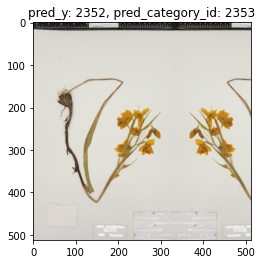

In [37]:
from PIL import Image
import matplotlib.pyplot as plt
idx = 0

img = Image.open(test_df.path[idx])
pred_y = preds.Predicted[idx]
pred_category_id = category_ids[idx]


ax = plt.imshow(img)
plt.title(f"pred_y: {pred_y}, pred_category_id: {pred_category_id}")

In [39]:
from PIL import Image
import matplotlib.pyplot as plt
idx = 0
samples = train_df[train_df.category_id==pred_category_id]

Text(0.5, 1.0, 'image_id: 02353__005')

Text(0.5, 1.0, 'image_id: 02353__035')

Text(0.5, 1.0, 'image_id: 02353__053')

Text(0.5, 1.0, 'image_id: 02353__014')

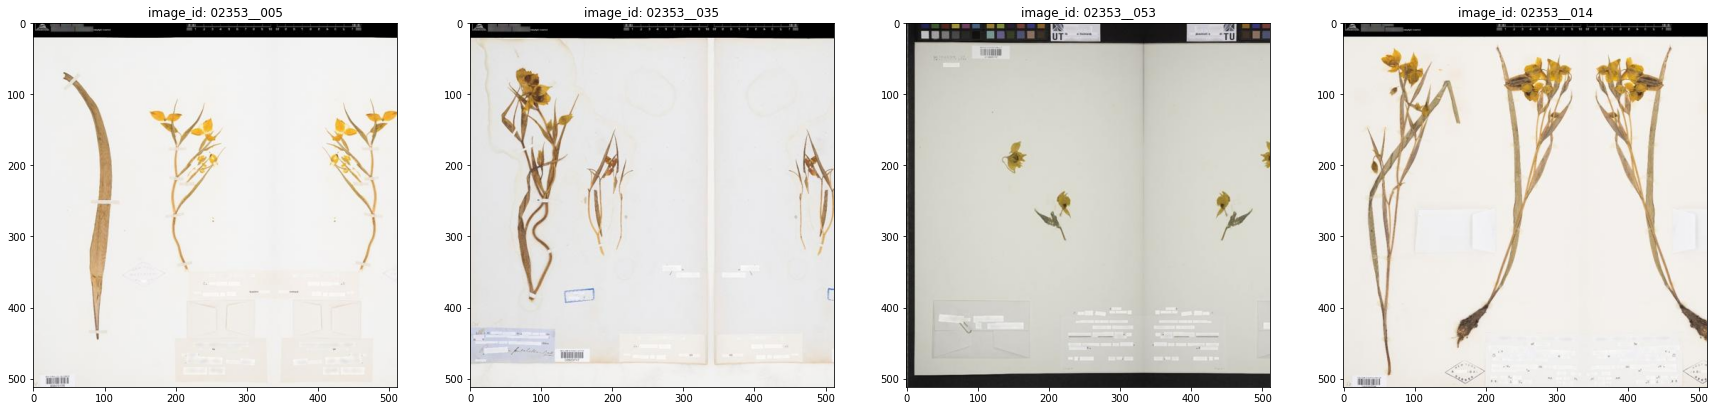

In [49]:
# i=0
fig, ax = plt.subplots(1,4, figsize=(30, 50))
for i in range(4):
    img = Image.open(samples.path.iloc[i])
    ax[i].imshow(img)
    ax[i].set_title(f"image_id: {samples.image_id.iloc[i]}")

# img

Text(0.5, 1.0, 'pred_y: 2352, pred_category_id: 2353')

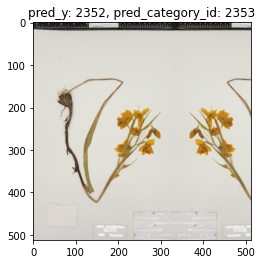

In [37]:
img = Image.open(train_df.path[idx])
pred_y = preds.Predicted[idx]
pred_category_id = category_ids[idx]


ax = plt.imshow(img)
plt.title(f"pred_y: {pred_y}, pred_category_id: {pred_category_id}")

In [28]:
pred_ids = preds.head(1000).Id.values


out = test_df[test_df.image_id.apply(lambda x: x in pred_ids)]
out

,idx,image_id,file_name,source_path,path


In [ ]:
preds = []
with torch.no_grad():
    for inputs in tqdm(test_dl):
        inputs['pixel_values'] = inputs['pixel_values'].to('cuda')
        outputs = model(**inputs)
        logits = outputs.logits
        preds.extend([x.item() for x in logits.argmax(-1)])
submit = pd.read_csv('../input/herbarium-2022-fgvc9/sample_submission.csv')
submit['Predicted'] = preds
submit.to_csv('beit.csv', index=False)

In [9]:
pp(OmegaConf.to_container(model.cfg, resolve=True))
results = {}
results['val'] = trainer.validate(model, datamodule=datamodule)
pp(results['val'])

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=07-val_loss=3.338-val_F1=0.313.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt = torch.load(ckpt_path)
# print(ckpt.keys())

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();

# batch[0] = batch[0].cuda()
# batch[1] = batch[1].cuda()
# x, y, metadata = batch
# x = x.to('cuda')
# y_logits = model(x)
# y_logits_top5 = torch.topk(torch.Tensor(y_logits.cpu()), k=5, dim=1)
# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()
# labels_k = le.decode_topk(y_logits_top5_idx)
# datamodule.train_dataset.label_encoder.classes_
# y_pred = torch.zeros_like(y_logits_top5.indices)
# topk_labels = np.empty((128,5), dtype="O")
# for k in range(5):
#     labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     topk_labels[:,k] = labels_k

## Other

In [9]:
import matplotlib.pyplot as plt

batch = (next(iter(datamodule.train_dataloader())))

x, y = batch[:2]

# import cv2
import torchvision
# read_img = cv2.imread


def plot_imgs(imgs,r=8,c=8,figsize=(20,20)):
    _, axs = plt.subplots(r,c,figsize=figsize)
    axs=axs.flatten()
    for n, ax in enumerate(axs):
        img=imgs[n]
        
        img = (img - img.min()) / (img.max() - img.min())
        
        ax.imshow(torchvision.transforms.functional.to_pil_image(img))
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()
    
    
    
plot_imgs(x)

In [26]:
def plot_layer_stats(self, idx):
    plt,axs = subplots(1, 3, figsize=(15,3))
    plt.subplots_adjust(wspace=0.5)
    for o,ax,title in zip(self.layer_stats(idx),axs,('mean','std','% near zero')):
        ax.plot(o)
        ax.set_title(f"{-1*layer}th layer {title}")
# for layer in range(1,4):
#     plot_layer_stats(learn.activation_stats,-1*layer)

tensor([ 9359,  9100,   699,  7888,  1765,  8122,  3237, 10139,    92,  4797,
         1177, 13626,  3192, 14096,  7230, 15228,  2946,  6897, 11806, 12283,
         5417, 14869,  1893, 11265, 10801, 10612, 14247,  7553,  1929,    95,
        12244,  3711,  8568,  7284, 12985, 13294,  5933, 13370, 13442, 14808,
         5069,  3534,  4449, 14373, 12346, 13173,  8813,  5822, 12290,  3871,
         6645,  8778,  7234, 13757, 14497, 15082, 12595,  9840,  5873,  7065,
        10484,  6040, 14399, 11489,  5271,  7599, 14529,  1344,  6127,  2569,
         3328,  5268,  6732, 12513, 14617,  5298, 10576, 15130,  4153,  4565,
         1048, 11556,  6358,  2921,  5793, 11842,  6929, 10982,  8839, 13874,
         5513, 12170,  9560,  3182,  5488,  1204,  6640, 11548,  3641, 13809,
         7082,  5689, 10308,  7468, 11267, 10716,  8750, 13361,  4504, 13840,
         3911,  8141,  4920,  3215,  8776, 12795, 12591,  3330,  9270,  8510,
        15130, 12557,  4753, 11097,  7270, 12230,  7938,  6044])

In [6]:
from imutils.ml.models.pl.classifier import LitClassifier

model = LitClassifier(cfg=cfg,
                      loss_func=loss_func)



In [10]:
run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45"
ckpt_dir = os.path.join(run_dir, "ckpts")

top_k = 3

ckpt_paths = [os.path.join(ckpt_dir, f) for f in sorted(os.listdir(ckpt_dir))[-top_k:]]
paths = []
for d in ckpt_paths:
    if os.path.isdir(d):
        for f in sorted(os.listdir(d)):
            paths.append(os.path.join(d, f))
    else:
        paths.append(d)
paths

['/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=26-val_loss=1.281-val_macro_F1=0.733/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=27-val_loss=1.290-val_macro_F1=0.734/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/last.ckpt']

In [11]:
import os
import wandb

os.environ["WANDB_PROJECT"]="herbarium2022"
!set | grep WANDB


artifact = wandb.Artifact("model-weights", "checkpoints")
# Add Files and Assets to the artifact using 
# `.add`, `.add_file`, `.add_dir`, and `.add_reference`
artifact.add_dir(ckpt_dir)
# artifact.add_file(ckpt_path)
artifact.save()




# api = wandb.Api()
# run = api.run("herbarium2022/37r673ke")
# run.upload_file(ckpt_path)
# for path in ckpt_paths:
#     print(f"Uploading file to wandb: {path}")
#     run.upload_file(path)
# run = wandb.init(project=PROJECT_NAME, resume=True)
# run.finish

BASH_EXECUTION_STRING='set | grep WANDB'
WANDB_API_KEY=4da22f6127e7f77527340ffede80688f6e9fb597
WANDB_CACHE_DIR=/media/data/jacob/wandb_cache
WANDB_ENTITY=jrose
WANDB_PROJECT=herbarium2022


wandb: Adding directory to artifact (/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts)... Done. 16.5s
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
%load_ext filprofiler

import psutil
from rich import print as pp
print(f"RAM memory % used: {psutil.virtual_memory()[2]}")

In [2]:
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
import sys

Importing imutils


In [3]:
%%filprofile

root_dir = "/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/catalogs"

ds = Herbarium2022Dataset(catalog_dir=root_dir, image_reader="PIL")

ds

=fil-profile= WARNING: Fil does not (yet) support tracking memory in subprocesses.
=fil-profile= Preparing to write to fil-result/tmpqvlwf71t
=fil-profile= Wrote flamegraph to "fil-result/tmpqvlwf71t/peak-memory.svg"
=fil-profile= Wrote flamegraph to "fil-result/tmpqvlwf71t/peak-memory-reversed.svg"


In [12]:
pp(dict(ds.df.iloc[0]))

path = ds.df.path[0]

{
    'idx': 800061,
    'Species': 'Trifolium fucatum',
    'path': '/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-
512/train_images/147/56/14756__047.jpg',
    'y': 14752,
    'category_id': 14756,
    'genus_id': 2443,
    'institution_id': 36,
    'image_id': '14756__047',
    'file_name': '147/56/14756__047.jpg',
    'scientificName': 'Trifolium fucatum Lindl.',
    'family': 'Fabaceae',
    'genus': 'Trifolium',
    'species': 'fucatum',
    'collectionCode': 'NY'
}

In [25]:
from PIL import Image
# %%filprofile
# img_bytes = img.tobytes()

%%filprofile

def display_obj_size(obj):
    img_mem = sys.getsizeof(obj)
    # img_mem = sys.getsizeof(img_bytes)
    print("img size in memory:")
    print(f"- {img_mem:,} bytes")
    print(f"- {img_mem/1000:,} kb")
    print(f"- {img_mem/1000/1000:,} Mb")
    
    
display_obj_size(img.tobytes())

In [35]:
import numpy as np
import cv2

In [76]:
%%filprofile

take_k = 50
paths = ds.df.path[:take_k]

imgs = []
for i, path in enumerate(paths):
    # img = Image.open(path)
    # img = np.asarray(img)
    with open(path,"rb") as f:
        # imgs.append(f.read())
        img_enc = f.read()
        
    img_buffer = np.frombuffer(img_enc, np.uint8)
    dec_img = cv2.imdecode(img_buffer, cv2.IMREAD_ANYCOLOR)
    img = dec_img[:,:,::-1]
        
    # img = cv2.imread(path)
    # if i < 3:
        # display_obj_size(img.tobytes())
    imgs.append(img)
    # break
    
imgs = np.stack(imgs)
# print(imgs.shape)

=fil-profile= Preparing to write to fil-result/tmprfhfp9fl
=fil-profile= Wrote flamegraph to "fil-result/tmprfhfp9fl/peak-memory.svg"
=fil-profile= Wrote flamegraph to "fil-result/tmprfhfp9fl/peak-memory-reversed.svg"


In [77]:
imgs.shape

display_obj_size(imgs[0])

# img_buffer = imgs[2]
img_enc = imgs[2]


# img_enc = base64.b64decode(img_b64_enc)
img_buffer = np.frombuffer(img_enc, np.uint8)
dec_img = cv2.imdecode(img_buffer, cv2.IMREAD_ANYCOLOR)
img = img[:,:,::-1]

dec_img.shape

Image.fromarray(dec_img[:,:,::-1])

In [27]:
%memit img_mem = sys.getsizeof(img.tobytes())

print("img size in memory:")
print(f"- {img_mem:,} bytes")
print(f"- {img_mem/1000:,} kb")
print(f"- {img_mem/1000/1000:,} Mb")

UsageError: Line magic function `%memit` not found.


In [ ]:
from io import BytesIO
img_file = BytesIO()
img.save(img_file, 'png')
img_file_size_png = img_file.tell()
img_file = BytesIO()
img.save(img_file, 'jpeg')
img_file_size_jpeg = img_file.tell()
print("img_file_size png: ", img_file_size_png)
print("img_file_size jpeg: ", img_file_size_jpeg)

In [24]:
import StringIO
output = StringIO.StringIO()
image_output.save(output, 'PNG') #a format needs to be provided
contents = output.getvalue()
output.close()

image_filesize = len(contents)

ram_info = psutil.virtual_memory()

for name, quantity in ram_info._asdict().items():
    if name == "percent":
        print(f"{name}: {quantity/100:.2%}")
    else:
        print(f"{name}: {quantity/1000/1000/1000:2,} GB")
        print(f"{name}: {quantity/1000/1000:2,} MB")
        print(f"{name}: {quantity/1000:.2e} kb")
    print("="*20)

# pp(ram_info)

# total, avail, perc = ram_info[:3]

In [12]:
print(f"{0.000012079806881608064:e}")

1.207981e-05


In [13]:
print(f"{0.0000027673238836757465:e}")

2.767324e-06


In [14]:
print(f"{0.000012079806881608064/0.0000027673238836757465:e}")

4.365158e+00


In [16]:
print(f"{0.0000027673238836757465/0.000012079806881608064}")

0.22908676527677738


In [2]:
!wandb sync --id "37r673ke" -p "herbarium2022" -e "jrose" --include-online "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/*"

'running'

In [55]:
(671817 + 167955)

train = 671817 / 24 / 4
val = 167955 / 24 / 4

train
val
train+ val

1/1.10
1/1.3
1/1.6

24/1.10
24/1.3
24/1.6

(24/1.10)**-1
(24/1.3)**-1
(24/1.6)**-1

24/1.62

In [3]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["data.datamodule.num_workers=4",
                                              "data/datamodule@data=herbarium2022-res_512_datamodule",
                                              # "train.pl_trainer.gpus=4",
                                              "train.pl_trainer.accelerator=gpu",
                                              "model_cfg.backbone.name=resnext50_32x4d"],
                                              # "model_cfg.backbone.name=resnet_50"],
                                              # "model_cfg.backbone.name=xcit_large_24_p16_224"],
                                              # "model_cfg.backbone.name=resnetv2_101x1_bitm"],
                                             # "model_cfg.backbone.name=resnetv2_50"], 
                                 cfg = None)




In [4]:
OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)

print(OmegaConf.to_yaml(cfg.hydra))#, resolve=True, sort_keys=True))

name 'HydraConfig' is not defined
/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17
run:
  dir: /media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17



## Instantiate experiment ingredients with config

In [5]:
from icecream import ic

# OmegaConf.register_new_resolver("int", int)

if cfg.train.deterministic:
    pl.seed_everything(cfg.train.random_seed)

if cfg.train.pl_trainer.fast_dev_run:
    hydra.utils.log.info(
        f"Debug mode <{cfg.train.pl_trainer.fast_dev_run}>. "
        f"Forcing debugger friendly configuration!"
    )
    cfg.train.pl_trainer.gpus = 0
    cfg.data.datamodule.num_workers = 0

try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    hydra_dir = os.getcwd()

hydra.utils.log.info(f"Instantiating <{cfg.data.datamodule._target_}>")
datamodule: pl.LightningDataModule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)
datamodule.setup()

self.transform_cfg:


{'preprocess': {'train': {'resize': 256}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 671817
    num_batches: 5249
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'val'
    num_samples: 167955
    num_batches: 1313
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'test'
    num_samples: 210407
    num_batches: 1644
    self.num_classes: 15501
    self.batch_size: 128


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from imutils.ml.utils.toolbox.nn.functional import sequence2np

from imutils.ml.utils.toolbox.nn.loss import CBCrossEntropyLoss



targets = datamodule.train_dataset.df.y

loss_func = CBCrossEntropyLoss(targets=targets,
                               beta=0.0,
                               reduction="mean")

assert np.all(loss_func.weights.numpy()==1.0)

targets = datamodule.train_dataset.df.y

loss_func = CBCrossEntropyLoss(targets=targets,
                               beta=0.99,
                               reduction="mean")

# np.all(loss_func.weights.numpy()==1.0)

w_max = loss_func.weights.numpy().max()
w_min = loss_func.weights.numpy().min()

w_sum = loss_func.weights.numpy().sum()
w_count = len(loss_func.weights)

print(f"w_max: {w_max:.5f}","\n",
      f"w_min: {w_min:.5f}","\n",
      f"w_sum: {w_sum:.5f}","\n",
      f"w_count: {w_count}")

w = loss_func.weights
w_max = loss_func.weights.numpy().max()
w_min = loss_func.weights.numpy().min()
w_normalized = (w - w_min) / (w_max - w_min)



for name, w in [("normalized weights", w_normalized), ("weights", loss_func.weights)]:

    w_max = w.numpy().max()
    w_min = w.numpy().min()

    w_sum = w.numpy().sum()
    w_count = len(w)

    print(f"{name}:", "\n", "="*10)
    print(f"w_max: {w_max:.5f}","\n",
          f"w_min: {w_min:.5f}","\n",
          f"w_sum: {w_sum:.5f}","\n",
          f"w_count: {w_count}", "\n")

In [30]:
loss_func.classes
reindex = np.argsort(loss_func.class_counts)[::-1]
reindex

array([    0,     1,     2, ..., 15498, 15499, 15500])

array([ 9740,  4556,  4422, ..., 14156, 13301, 14452])

In [35]:
ordered_class_counts = loss_func.class_counts[reindex]
ordered_class_weights = loss_func.weights.numpy()[reindex]


In [9]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=False)
ax[0].plot(ordered_class_counts/np.sum(ordered_class_counts))
ax[1].plot(np.exp(ordered_class_weights))

dir(loss_func)

In [ ]:
weights = torch.tensor([9.8, 68.0, 5.3, 3.5, 10.8, 1.1, 1.4], dtype=torch.float32)
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)

In [60]:
y = datamodule.train_dataset.df.y

counts_df = y.value_counts()

In [14]:
# y = sequence2np(y)
# classes, class_counts = np.unique(y, return_counts=True)
# print(type(classes), type(class_counts))
# for label in range(15000):
#     assert class_counts[label] == counts_df[label]
# y = y.values.to_numpy()
# y.shape
# import numpy as np

In [7]:
# logging.warning("1. Before model, before trainer")
hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(cfg.model, cfg=cfg, _recursive_=False)
# model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
#                                                       loss_func=cfg.model_cfg.loss)

# logging.warning("2. After model, before trainer")
# ic(torch.cuda.current_device())	
# ic(torch.cuda.get_device_name(0))
wandb_logger = configure_loggers(cfg=cfg, model=model)
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train)	
hydra.utils.log.info(f"Instantiating the Trainer")
pp(OmegaConf.to_container(cfg.train.pl_trainer))
trainer = configure_trainer(cfg,
                            callbacks=callbacks,
                            logger=wandb_logger)
# logging.warning("3. After model, after trainer, before fit")
# ic(torch.cuda.current_device())
num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]
hydra.utils.log.info("Starting training with {} classes across {} images in batches of {} images each.".format(
    num_classes,
    num_samples,
    batch_size))



NameError: name 'model' is not defined

In [12]:
datamodule.test_dataset.test_transform = None

In [13]:
datamodule.test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [21]:
from tqdm import tqdm

loader = datamodule.test_dataloader()
for i, batch in tqdm(enumerate(iter(loader)), total = len(loader)):
    if i > 50:
        break

  3%|██▉                                                                                          | 51/1644 [01:52<58:35,  2.21s/it]


In [26]:
128*2.21

282.88

In [23]:
64*

128

In [19]:
from PIL import Image
img = Image.open(datamodule.test_dataset.df.path.iloc[0])
img.size

img

In [10]:
import meerkat as mk
# from meerkat.contrib.imagenette import download_imagenette


# dp_csv_path = datamodule.train_dataset.split_file_path
dp_csv_path = datamodule.test_dataset.split_file_path

# download_imagenette(".")
dp = mk.DataPanel.from_csv(dp_csv_path)
dp["img"] = mk.ImageColumn.from_filepaths(dp["path"],
                                          transform=datamodule.test_transform)
# dp[["scientificName", "image_id", "img"]].lz[:3]
dp[["image_id", "img"]].lz[:3]

,image_id (PandasSeriesColumn),img (ImageColumn)
0,0,"tensor([[[1.4783, 1.4783, 1.4783, ..., 1.4440, 1.4184, 1.3584], [1.4783, 1.4783, 1.4783, ..., 1.4697, 1.4440, 1.4141], [1.4783, 1.4783, 1.4783, ..., 1.4697, 1.4483, 1.4440], ..., [1.7095, 1.6881, 1.6881, ..., 1.9920, 2.0092, 2.0006], [1.7865, 1.7694, 1.7694, ..., 1.9920, 2.0092, 2.0177], [1.8764, 1.8550, 1.8550, ..., 1.9835, 2.0092, 2.0263]], [[1.2031, 1.2031, 1.2031, ..., 1.1681, 1.1418, 1.0805], [1.2031, 1.2031, 1.2031, ..., 1.1943, 1.1681, 1.1374], [1.2031, 1.2031, 1.2031, ..., 1.1943, 1.1724, 1.1681], ..., [1.8071, 1.7852, 1.7852, ..., 2.0434, 2.0259, 2.0172], [1.8859, 1.8683, 1.8683, ..., 2.0434, 2.0259, 2.0347], [1.9778, 1.9559, 1.9559, ..., 2.0347, 2.0434, 2.0434]], [[0.4788, 0.4788, 0.4788, ..., 0.4439, 0.4178, 0.3568], [0.4788, 0.4788, 0.4788, ..., 0.4701, 0.4439, 0.4134], [0.4788, 0.4788, 0.4788, ..., 0.4701, 0.4483, 0.4439], ..., [1.8295, 1.8078, 1.8078, ..., 2.0823, 2.0823, 2.0736], [1.8905, 1.8731, 1.8731, ..., 2.0823, 2.0823, 2.0910], [1.9820, 1.9603, 1.9603, ..., 2.0823, 2.0997, 2.1084]]])"
1,1,"tensor([[[1.4569, 1.4269, 1.4355, ..., 1.6453, 1.6924, 1.6838], [1.4783, 1.4783, 1.4697, ..., 1.4997, 1.5810, 1.5982], [1.8208, 1.6924, 1.4612, ..., 1.5168, 1.6196, 1.6367], ..., [1.4055, 1.3970, 1.3798, ..., 1.3156, 1.3156, 1.3156], [1.3670, 1.3499, 1.3627, ..., 1.2985, 1.2985, 1.2985], [1.3242, 1.3584, 1.3970, ..., 1.2899, 1.2899, 1.2899]], [[1.4963, 1.4657, 1.4744, ..., 1.7677, 1.8158, 1.7896], [1.5182, 1.5182, 1.5095, ..., 1.6276, 1.7108, 1.7108], [1.8683, 1.7370, 1.5007, ..., 1.6276, 1.7327, 1.7458], ..., [1.5488, 1.5401, 1.5226, ..., 1.3519, 1.3519, 1.3519], [1.5095, 1.4919, 1.5051, ..., 1.3344, 1.3344, 1.3344], [1.4526, 1.4832, 1.5226, ..., 1.3256, 1.3256, 1.3256]], [[1.3982, 1.3677, 1.3764, ..., 1.7511, 1.7990, 1.7903], [1.4200, 1.4200, 1.4112, ..., 1.5812, 1.6640, 1.6901], [1.7773, 1.6378, 1.4025, ..., 1.5812, 1.6858, 1.7119], ..., [1.7206, 1.7206, 1.7032, ..., 1.2544, 1.2544, 1.2544], [1.6553, 1.6378, 1.6509, ..., 1.2370, 1.2370, 1.2370], [1.5332, 1.5768, 1.6160, ..., 1.2282, 1.2282, 1.2282]]])"
2,2,"tensor([[[1.5810, 1.6067, 1.6153, ..., 1.6453, 1.7052, 1.6709], [1.6281, 1.6410, 1.6367, ..., 1.6067, 1.6410, 1.6752], [1.6110, 1.6367, 1.6410, ..., 1.8122, 1.7523, 1.6881], ..., [1.6024, 1.6067, 1.5982, ..., 1.9064, 1.9193, 1.9278], [1.5725, 1.5896, 1.5682, ..., 1.8936, 1.9064, 1.9150], [1.5511, 1.5639, 1.5554, ..., 1.9021, 1.9150, 1.9235]], [[1.7108, 1.7370, 1.7458, ..., 1.7677, 1.8683, 1.8596], [1.7589, 1.7721, 1.7677, ..., 1.7195, 1.8027, 1.8771], [1.7414, 1.7677, 1.7721, ..., 1.9296, 1.9121, 1.8902], ..., [1.7502, 1.7546, 1.7458, ..., 2.0259, 2.0390, 2.0478], [1.7195, 1.7370, 1.7152, ..., 2.0128, 2.0259, 2.0347], [1.6933, 1.7064, 1.6977, ..., 2.0128, 2.0259, 2.0347]], [[1.6727, 1.6988, 1.7075, ..., 1.6596, 1.7990, 1.8383], [1.7119, 1.7250, 1.7206, ..., 1.5942, 1.7337, 1.8470], [1.6945, 1.7206, 1.7250, ..., 1.8121, 1.8557, 1.8600], ..., [1.6509, 1.6553, 1.6465, ..., 1.9080, 1.9210, 1.9298], [1.6204, 1.6378, 1.6160, ..., 1.8949, 1.9080, 1.9167], [1.6073, 1.6204, 1.6117, ..., 1.8731, 1.8818, 1.8905]]])"


In [13]:
dp["img"][3].shape

torch.Size([3, 224, 224])

In [15]:
import numpy as np
blue_col = dp.map(
    lambda x: np.array(x["img"])[2, :, :].mean(), 
    # lambda x: np.array(x["img"])[:, :, 2].mean(), 
    pbar=True, 
    num_workers=2
)
dp["avg_blue"] = blue_col  # add the intensities as a new column in the `DataPanel` 

dp

In [9]:
type(dp["img"][0])

# dir(dp["img"].data)
dp["img"].data

In [23]:
# 1. Define the forward hook
class ActivationExtractor:
    """Extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def forward_hook(self, module, input, output):
        self.activation = output

# model.setup()
# 2. Register the forward hook
extractor = ActivationExtractor()
model.net.backbone.layer4.register_forward_hook(extractor.forward_hook);

In [24]:
import torch

import meerkat.ml as mkml
# 1. Move the model to GPU
model.to(0).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["img"] 
    x: torch.Tensor = input_col.data.to(0)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu(),
        "activation": mkml.EmbeddingColumn(extractor.activation.mean(dim=[-1,-2]).cpu())
    }



valid_dp = dp.lz[:100]
# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `is_batched_fn=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
valid_dp = valid_dp.update(
    function=predict,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["img"], 
    pbar=True
)



In [17]:
!conda list

# dp["img"]
updated_dp

pp(OmegaConf.to_container(model.cfg, resolve=True))

In [9]:
# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=14-val_loss=2.521-val_F1=0.443.ckpt"

ckpt_dir = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts"


model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();


results = []

for batch in iter(test_dataloader):
    x, y, metadata = batch
    x.to(model.device)
    image_ids = metadata['image_id']
    
    y_logits = model.predict_step(x)
    
    results.append({"image_id": image_ids,
                    "y_logits: y_logits"})

pp(OmegaConf.to_container(model.cfg, resolve=True))

# dir()

results = {}

results['val'] = trainer.validate(model, datamodule=datamodule)

pp(results['val'])

# datamodule.test_dataset.df
# datamodule.train_dataset.df
import numpy as np
import torch

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=07-val_loss=3.338-val_F1=0.313.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt = torch.load(ckpt_path)
# print(ckpt.keys())

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();
# model.to("cpu")

# test_loader = datamodule.test_dataloader()
# batch = next(iter(test_loader))

# batch[1]#.cpu()

# batch[:2] = (b.cuda() for b in batch[:2])
# [b.cuda() for b in batch[:2]]

# batch[0] = batch[0].cuda()
# batch[1] = batch[1].cuda()
# x, y, metadata = batch
# x = x.to('cuda')
# y_logits = model(x)
# y_logits_top5 = torch.topk(torch.Tensor(y_logits.cpu()), k=5, dim=1)
# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()
# labels_k = le.decode_topk(y_logits_top5_idx)
# datamodule.train_dataset.label_encoder.classes_
# y_pred = torch.zeros_like(y_logits_top5.indices)
# topk_labels = np.empty((128,5), dtype="O")
# for k in range(5):
#     labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     topk_labels[:,k] = labels_k

In [7]:
# logging.warning("1. Before model, before trainer")
hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(cfg.model, cfg=cfg, _recursive_=False)
# model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
#                                                       loss_func=cfg.model_cfg.loss)

# logging.warning("2. After model, before trainer")
# ic(torch.cuda.current_device())	
# ic(torch.cuda.get_device_name(0))
wandb_logger = configure_loggers(cfg=cfg, model=model)
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train)	
hydra.utils.log.info(f"Instantiating the Trainer")
pp(OmegaConf.to_container(cfg.train.pl_trainer))
trainer = configure_trainer(cfg,
                            callbacks=callbacks,
                            logger=wandb_logger)
# logging.warning("3. After model, after trainer, before fit")
# ic(torch.cuda.current_device())
num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]
hydra.utils.log.info("Starting training with {} classes across {} images in batches of {} images each.".format(
    num_classes,
    num_samples,
    batch_size))



NameError: name 'model' is not defined

In [6]:
trainer.fit(model=model, datamodule=datamodule)

name 'HydraConfig' is not defined
self.transform_cfg:


{'preprocess': {'train': {'resize': 256}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 587840
    num_batches: 4593
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'val'
    num_samples: 251932
    num_batches: 1969
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'test'
    num_samples: 210407
    num_batches: 1644
    self.num_classes: 15501
    self.batch_size: 128


In [17]:
from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(cfg['data']['datamodule']['transform_cfg'])

type(cfg.model_cfg.input_shape)
type(OmegaConf.to_container(cfg.model_cfg.input_shape, resolve=True)[0])

Initializing weights of the model head.
input_size: (1, 3, 224, 224)
_target_: imutils.ml.models.pl.classifier.LitClassifier
backbone:
  freeze_backbone: false
  model_repo: timm
  name: resnext50_32x4d
  pretrained: true
head:
  dropout_p: 0.3
  head_type: linear
  hidden_size: 512
  num_classes: 15501
  pool_size: 1
  pool_type: avg
input_shape:
- 3
- 224
- 224
loss:
  _target_: torch.nn.CrossEntropyLoss
name: resnext50_32x4d
num_channels: 3
resolution: 224



omegaconf.listconfig.ListConfig

int

In [ ]:
# Instantiate model
# hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(model_cfg=cfg, _recursive_=False)


from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# input_size = (1, 3,224,224)
# summary = log_model_summary(model=model,
#                             input_size=input_size,
#                             full_summary=True,
#                             working_dir=".",
#                             model_name=cfg.model_cfg.backbone.name,
#                             verbose=1)

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer

# Instantiate the callbacks
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train) #OmegaConf.to_container(cfg.train, resolve=True))

model.freeze_up_to(layer=-1,
                  submodule="backbone")

# ([(n, p.requires_grad_(False)) for n, p in model.net.backbone.named_parameters()])
pp([(n, p.requires_grad) for n, p in model.net.backbone.named_parameters()])

In [11]:
# datamodule.test_dataset.df
# datamodule.train_dataset.df
import numpy as np
import torch

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=07-val_loss=3.338-val_F1=0.313.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt = torch.load(ckpt_path)
# print(ckpt.keys())

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();
# model.to("cpu")

# test_loader = datamodule.test_dataloader()
# batch = next(iter(test_loader))

# batch[1]#.cpu()

In [13]:
# batch[:2] = (b.cuda() for b in batch[:2])
# [b.cuda() for b in batch[:2]]

# batch[0] = batch[0].cuda()
# batch[1] = batch[1].cuda()
# x, y, metadata = batch
# x = x.to('cuda')
# y_logits = model(x)
# y_logits_top5 = torch.topk(torch.Tensor(y_logits.cpu()), k=5, dim=1)
# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()
# labels_k = le.decode_topk(y_logits_top5_idx)
# datamodule.train_dataset.label_encoder.classes_
# y_pred = torch.zeros_like(y_logits_top5.indices)
# topk_labels = np.empty((128,5), dtype="O")
# for k in range(5):
#     labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     topk_labels[:,k] = labels_k

#### Dev topk predictions

In [31]:
# import numpy as np
# topk_labels = [] #np.empty((128,5), dtype="string")

# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()

# y = y_logits_top5_idx#.shape[1]

# if isinstance(y, np.ndarray):
#     if y.ndim == 2:
#         topk = y.shape[1]
#     else:
#         topk = 1
# if isinstance(y, list):
#     if isinstance(y[0], np.ndarray):
#         topk = y[0].shape[0]
#     elif isinstance(y[0], list):
#         topk = len(y[0])

# for k in range(topk):
#     # labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     labels_k = le.decode(y[:,k])
#     topk_labels.append(labels_k)

In [23]:
# topk_labels = np.vstack(topk_labels).T
# topk_labels.shape

# topk_labels[:2,:]
# true_labels = le.decode(y.numpy())
# topk_labels[0]

# from sklearn import preprocessing
# encoder = preprocessing.LabelEncoder()
# encoder.fit([0,4,-2,6])
# encoder.classes_

# class_list = getattr(encoder, "classes_", [])
# class2idx = {label: idx for idx, label in enumerate(class_list)}
# print(class2idx)

In [19]:
from imutils.ml.utils.label_utils import LabelEncoder

le = LabelEncoder.from_sklearn(datamodule.train_dataset.label_encoder)
le

In [ ]:
from typing import *
from imutils.ml.utils.model_utils import log_model_summary

log_model_summary(model, input_size=(2,3,224,224))

ckpt['epoch']
ckpt['global_step']
ckpt['pytorch-lightning_version']
ckpt['hparams_name']
ckpt['hyper_parameters']

In [50]:

datamodule.test_dataset.y_col
getattr(datamodule.test_dataset.df, "y", -1)
# df = datamodule.train_dataset.df
df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
above_25 = class_counts[class_counts.counts>=25]
above_10 = class_counts[class_counts.counts>=10]
above_5 = class_counts[class_counts.counts>=5]

below_5 = class_counts[class_counts.counts<5]
below_10 = class_counts[class_counts.counts<10]
below_25 = class_counts[class_counts.counts<25]

print("Min: ", min(class_counts.counts),"Max:", max(class_counts.counts))
pp(f"above_25: {above_25.shape[0]}, {above_25.shape[0] / num_classes:.4%}")
pp(f"above_10: {above_10.shape[0]}, {above_10.shape[0] / num_classes:.4%}")
pp(f"above_5: {above_5.shape[0]}, {above_5.shape[0] / num_classes:.4%}")

# pp(above_10.shape[0], above_10.shape[0] / num_classes)
# pp(above_5.shape[0], above_5.shape[0] / num_classes)

pp(f"below_5: {below_5.shape[0]}, {below_5.shape[0] / num_classes:.4%}")
pp(f"below_10: {below_10.shape[0]}, {below_10.shape[0] / num_classes:.4%}")
pp(f"below_25: {below_25.shape[0]}, {below_25.shape[0] / num_classes:.4%}")
# pp(below_10.shape[0], below_10.shape[0] / num_classes)
# pp(below_25.shape[0], below_25.shape[0] / num_classes)

In [57]:
def filter_catalog(catalog: pd.DataFrame,
                   column: str,
                   include=None,
                   exclude=None) -> pd.DataFrame:
    num_rows = catalog.shape[0]
    if isinstance(include, Sequence):
        pp(f"Including {len(include)}")
        catalog = catalog[catalog[column].apply(lambda x: x in include)]
    if isinstance(exclude, Sequence):
        pp(f"Excluding {len(exclude)}")
        
        catalog = catalog[catalog[column].apply(lambda x: x not in exclude)]

    pp(f"Input num_rows: {num_rows}")
    pp(f"Filtered num_rows: {catalog.shape[0]}, {catalog.shape[0]/num_rows:.3%}")
        
    return catalog

df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
                # datamodule.test_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
above_20 = None
below_20 = class_counts[class_counts.counts<40].counts
below_20 = below_20.values.tolist()
above_20_catalog = filter_catalog(catalog=df,
                                  column="y",
                                  include=above_20,
                                  exclude=below_20)
above_20_catalog

Excluding 4471

Input num_rows: 839772

Filtered num_rows: 837841, 99.770%

,index,Species,path,y,category_id,genus_id,institution_id,image_id,file_name,license,scientificName,family,genus,species,authors,collectionCode
0,800061,Trifolium fucatum,/media/data_cifs/projects/prj_fossils/data/raw...,14752,14756,2443,36,14756__047,147/56/14756__047.jpg,0,Trifolium fucatum Lindl.,Fabaceae,Trifolium,fucatum,Lindl.,NY
1,294940,Eragrostis urbaniana,/media/data_cifs/projects/prj_fossils/data/raw...,5484,5486,895,36,05486__011,054/86/05486__011.jpg,0,Eragrostis urbaniana Hitchc.,Poaceae,Eragrostis,urbaniana,Hitchc.,NY
2,546499,Osmorhiza purpurea,/media/data_cifs/projects/prj_fossils/data/raw...,10087,10091,1726,24,10091__046,100/91/10091__046.jpg,0,Osmorhiza purpurea (J.M.Coult. & Rose) Suksd.,Apiaceae,Osmorhiza,purpurea,(J.M.Coult. & Rose) Suksd.,ID
3,162934,Castilleja minor,/media/data_cifs/projects/prj_fossils/data/raw...,3088,3090,446,25,03090__061,030/90/03090__061.jpg,0,Castilleja minor (A.Gray) A.Gray,Orobanchaceae,Castilleja,minor,(A.Gray) A.Gray,IDS
4,206860,Corchorus hirsutus,/media/data_cifs/projects/prj_fossils/data/raw...,3894,3896,624,36,03896__020,038/96/03896__020.jpg,0,Corchorus hirsutus L.,Malvaceae,Corchorus,hirsutus,L.,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251927,667196,Quercus sinuata,/media/data_cifs/projects/prj_fossils/data/raw...,12301,12305,2023,13,12305__098,123/05/12305__098.jpg,0,Quercus sinuata Walter,Fagaceae,Quercus,sinuata,Walter,COLO
251928,735162,Sideroxylon lanuginosum,/media/data_cifs/projects/prj_fossils/data/raw...,13559,13563,2212,52,13563__050,135/63/13563__050.jpg,0,Sideroxylon lanuginosum Michx.,Sapotaceae,Sideroxylon,lanuginosum,Michx.,US
251929,127497,Campanula scabrella,/media/data_cifs/projects/prj_fossils/data/raw...,2464,2465,401,52,02465__029,024/65/02465__029.jpg,0,Campanula scabrella Engelm.,Campanulaceae,Campanula,scabrella,Engelm.,US
251930,359284,Gentiana clausa,/media/data_cifs/projects/prj_fossils/data/raw...,6666,6668,1021,21,06668__011,066/68/06668__011.jpg,0,Gentiana clausa Raf.,Gentianaceae,Gentiana,clausa,Raf.,GH


In [29]:
class_counts.describe()

# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
# above_20 = None
below_20 = class_counts[class_counts.counts<40] # .counts

below_20.describe()

datamodule.val_dataset.df.value_counts("y")

dir(datamodule.train_dataset.df.groupby("y"))



train --> (num_samples: 587,840), (num_batches: 9,185)
train --> (num_samples: 587,840), (num_batches: 9,185)
val --> (num_samples: 251,932), (num_batches: 3,937)
val --> (num_samples: 251,932), (num_batches: 3,937)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


In [19]:
# val_loader = datamodule.val_dataloader()

# batch = next(iter(val_loader))

# len(batch)

# import torch
# from torch import nn
# # Single-label categorical
# x = torch.randn(10, 5)
# y = torch.randint(5, (10,))
# loss = nn.CrossEntropyLoss()(x, y)


# print(x.shape, y.shape, loss.shape)
# print(x.dtype, y.dtype, loss.dtype)

# # model

# num_samples = len(datamodule.train_dataset)
# num_batches = len(datamodule.train_dataloader())

# ic(num_samples, num_batches, num_samples/ num_batches)

# import numpy as np

# print(f"{2264842/2:,}")

# print(f"{2264842/3:,}")

# ic(num_samples * np.arange(5))

In [46]:
# datamodule.setup_transforms(datamodule.transform_cfg)
# from imutils.ml.data.datamodule import get_default_transforms
# a = get_default_transforms(mode="train", config=datamodule.transform_cfg)

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


Compose(
    Preprocess(
  (resize_func): Resize(size=512, interpolation=bilinear)
)
    BatchTransform(
  (transforms): Sequential(
    (0): RandomPerspective(p=0.5)
    (1): RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    (2): RandomHorizontalFlip(p=0.5)
    (3): RandomVerticalFlip(p=0.5)
    (4): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
)
)

In [12]:
import wandb
def configure_loggers(cfg):

    wandb_logger = None
    if "wandb" in cfg.logging:
        hydra.utils.log.info(f"Instantiating <WandbLogger>")
        wandb_config = cfg.logging.wandb
        wandb_logger = pl.loggers.WandbLogger(
            name=wandb_config
            .get("name", 
                           (cfg.data.datamodule.get("name") + "__" + cfg.model_cfg.name)),
            project=wandb_config.project,
            entity=wandb_config.entity,
            tags=cfg.core.tags,
            log_model=True,
        )
        hydra.utils.log.info(f"W&B is now watching <{wandb_config.watch.log}>!")
        wandb_logger.watch(
            model, log=wandb_config.watch.log, log_freq=wandb_config.watch.log_freq
        )


        hydra.utils.log.info(f"Instantiating the Trainer")
    return wandb_logger

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [22]:
# wandb_logger = configure_loggers(cfg=cfg, model=model)
# print(wandb_logger)

# # The Lightning core, the Trainer
# trainer = pl.Trainer(
#     default_root_dir=cfg.hydra.run.dir,
#     logger=wandb_logger,
#     callbacks=callbacks,
#     deterministic=cfg.train.deterministic,
#     val_check_interval=cfg.logging.val_check_interval,
#     log_every_n_steps=10,
#     #auto_select_gpus=True,
#     # benchmark=True,
#     # accelerator=None,  # 'dp', "ddp" if args.gpus > 1 else None,
#     #plugins=[DDPPlugin(find_unused_parameters=True)],
#     **cfg.train.pl_trainer,
# )
# # num_samples = len(datamodule.train_dataset)
# num_classes = cfg.model_cfg.head.num_classes
# batch_size = datamodule.batch_size #["train"]
# hydra.utils.log.info("Starting training with {} classes and batches of {} images".format(
#     num_classes,
#     batch_size))
# # pp(OmegaConf.to_container(cfg.train.callbacks, resolve=True))
# trainer.fit(model=model, datamodule=datamodule)
# #%debug
# hydra.utils.log.info(f"Starting testing!")
# trainer.test(model=model, datamodule=datamodule)
# shutil.copytree(".hydra", Path(wandb_logger.experiment.dir) / "hydra")

## Measure time and function wrapping

In [22]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        from time import time
        start = time()
        result = func(*args, **kwargs)
        total_time = time() - start
        print(f'Elapsed time is {total_time} ms')
        
        if isinstance(result, int):
            print(f"{result}/{total_time} = {result/(total_time):.3f} samples/sec")
        return result
    return wrapper

In [13]:
# from tqdm import tqdm

@measure_time
def loop_through_dataloader(dataloader, num_batches):
    data_iter = iter(dataloader)
    for i, batch in tqdm(enumerate(data_iter), total=num_batches):
        if i > num_batches-1:
            break
    num_samples = i*len(batch[0])
    return num_samples



# train_iter = iter(datamodule.train_dataloader())
# datamodule.setup()
# dataloader = datamodule.train_dataloader()
# num_batches = 40
# loop_through_dataloader(dataloader, num_batches)
# bb = next(iter(dataloader))
# pp(datamodule.cfg)
# pp(OmegaConf.to_container(datamodule.cfg))

In [11]:
type(datamodule.cfg)

omegaconf.dictconfig.DictConfig

In [4]:

# default_cfg = DictConfig(dict(
#     catalog_dir=None,
#     label_col="scientificName",
#     train_size=0.7,
#     shuffle=True,
#     seed=14,
#     batch_size = 128,
#     num_workers = None,
#     pin_memory=True,
#     transform_cfg=None,
#     remove_transforms=False,
# ))

# from rich import print as pp

# pp(OmegaConf.to_yaml(default_cfg))

### Mock config yaml

In [ ]:
# CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      num_workers=4,
#                                      # image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()

# subset = "train"
# dataset = datamodule.get_dataset(subset=subset)

# dataset.num_classes

# trainer.fit(model, datamodule)

## End

In [ ]:
# from torchvision import transforms as T
# import argparse
# from rich import print as pp

# args = argparse.Namespace(
#     preprocess={
#         "train":{
#             "resize":512
#         },
#         "val":{
#             "resize":256
#         },
#     },
#     batch_transform={
#         "train":{
#             "random_resize_crop":224
#         },
#         "val":{
#             "center_crop":224
#         },
#     normalize=(
#        [0.485, 0.456, 0.406],
#        [0.229, 0.224, 0.225]
#     )
#     }
# )
# pp(args)

# kornia_transform = nn.Sequential(
#     K.RandomHorizontalFlip(),
#     K.RandomVerticalFlip(),
#     K.RandomMotionBlur(3, 35., 0.5),
#     K.RandomRotation(degrees=45.0),
#     K.Normalize(mean=mean_std,std=mean_std)
# )

# import numpy as np
# from torch import nn
# import torch
# from albumentations.augmentations import transforms as AT

# to_tensor = T.ToTensor()

# class Preprocess(nn.Module):

#     def __init__(self, mode="train", resize=None):
#         super().__init__()
#         self.mode = mode
#         self.resize = resize        
#         self.resize_func = T.Resize(self.resize)
    
#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x) -> torch.Tensor:
#         # x_tmp: np.ndarray = np.array(x)  # HxWxC
#         # x_out: Tensor = to_tensor(x_tmp, keepdim=True)  # CxHxW
#         if self.resize:
#             x = self.resize_func(x)

#         return x #_out.float()# / 255.0




# class BatchTransforms(nn.Module):
#     """Module to perform data augmentation using Kornia on torch tensors."""

#     def __init__(self,
#                  mode: str="train",
#                  random_resize_crop=None,
#                  center_crop=None,
#                  apply_color_jitter: bool = False,
#                  normalize = (
#                      [0,0,0],
#                      [1,1,1]
#                  )
#                 ) -> None:
#         super().__init__()
#         self.mode = mode
#         self.random_resize_crop = random_resize_crop
#         self.center_crop = center_crop
#         self._apply_color_jitter = apply_color_jitter
#         self.normalize = normalize
        
#         self.build_transforms(mode=mode)

        
#     def add_train_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         # if mode == "train":
#         transforms.append(T.RandomPerspective())
#         if type(self.random_resize_crop) == int:
#             transforms.append(T.RandomResizedCrop(self.random_resize_crop))
#         transforms.extend([
#             T.RandomHorizontalFlip(),
#             T.RandomVerticalFlip()
#         ])
#         return transforms

#     def add_test_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         if type(self.center_crop) == int:
#             transforms.append(T.CenterCrop(self.center_crop))
#         return transforms


#     def build_transforms(self,
#                          mode: str = "train"):
#         transforms = []
#         if mode == "train":
#             transforms = self.add_train_transforms(transforms=transforms)
#         elif mode in ["val", "test"]:
#             transforms = self.add_test_transforms(transforms=transforms)

#         transforms.extend([
# 			# T.ToTensor(),
# 			T.Normalize(*self.normalize)
#         ])

#         self.transforms = nn.Sequential(*transforms)
#         self.jitter = AT.ColorJitter(brightness=0.2,
#                                      contrast=0.2,
#                                      saturation=0.2,
#                                      hue=0.2,
#                                      always_apply=False,
#                                      p=0.5)

#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x_out = self.transforms(x)  # BxCxHxW
#         if self._apply_color_jitter:
#             x_out = self.jitter(x_out)
#         return x_out







# for subset in ["train","val", "test"]:
#     data = Herbarium2022Dataset(subset=subset,
#                                 label_col="scientificName",
#                                 train_size=0.7,
#                                 shuffle=(subset != "test"),
#                                 seed=14,
#                                 transform=None)

#########################################

CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"
SHARD_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/webdataset"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      batch_size=64,
#                                      num_workers=4,
#                                      image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()


# train_dataloader = datamodule.train_dataloader()
# train_batch = next(iter(train_dataloader))
# datamodule.train_dataset.encoder.inverse_transform(train_batch[1])

# checkpoint_callback = [c for c in callbacks if isinstance(c, pl.callbacks.ModelCheckpoint)][0]
# logging.info(f"checkpoint_callback.best_model_path: {str(checkpoint_callback.best_model_path)}")
# config.system.tasks[f"task_{task_id}"].ckpt_path = checkpoint_callback.best_model_path
# checkpoint_callback.best_model_score = checkpoint_callback.best_model_score or 0.0
# logging.info(f"checkpoint_callback.best_model_score: {checkpoint_callback.best_model_score:.3f}")
# logging.info(f"[Initiating TESTING on task_{task_id}]")


# test_results = run_multitask_test(trainer=trainer,
#                               model=model,
#                               datamodule=datamodule,
#                               config=config,
#                               tasks="all")#,